<a href="https://colab.research.google.com/github/mikemiller97/disaster-prediction/blob/main/nlp_disaster_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing with Disaster Tweets
>Predict which Tweets are about real disasters and which ones are not

## 1. Problem Definition

The following description is taken from the [Kaggle competition page](https://www.kaggle.com/competitions/nlp-getting-started/overview)
>Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

>In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.

## 2. Data
>The data has been taken from the same Kaggle competition. The data has been broken down into a testing and training set with a sample submission file.

## 3. Features

|Variable | Definition|
|----------|------------|
|id | a unique identifier for each tweet|
|text | the text of the tweet|
|location | the location the tweet was sent from (may be blank)|
|keyword | a particular keyword from the tweet (may be blank)|
|target | in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)|


## Imports

In [ ]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00


In [ ]:
#Preparing preprocessing model
!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.8 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found 

In [ ]:
!pip install keras-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 23.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import tensorflow as tf

import tensorflow_text as text
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_nlp
from sklearn.ensemble import RandomForestClassifier

## Data Exploration

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/nlp-disaster-classification/train.csv", index_col="id")
test = pd.read_csv("/content/drive/MyDrive/nlp-disaster-classification/test.csv", index_col="id")

In [ ]:
train.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
train.columns

Index(['keyword', 'location', 'text', 'target'], dtype='object')

In [ ]:
train.dtypes

keyword     object
location    object
text        object
target       int64
dtype: object

In [ ]:
train.isna().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

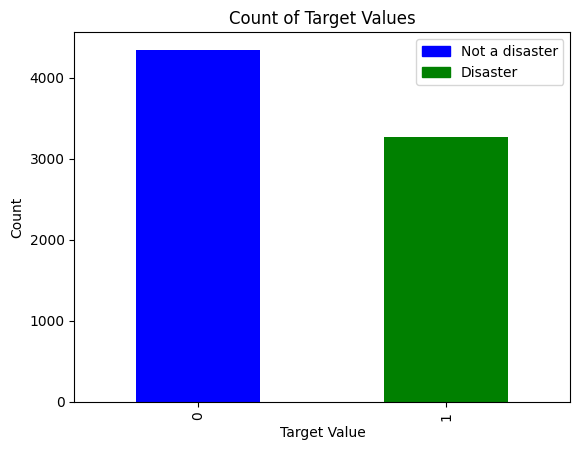

In [ ]:
result = train.groupby("target").size()

# Create a bar graph with custom colors
ax = result.plot(kind="bar", color=["blue", "green"])

# Adding labels and title
plt.xlabel("Target Value")
plt.ylabel("Count")
plt.title("Count of Target Values")

# Create colored patches for the legend
colors = ["blue", "green"]
labels = ["Not a disaster", "Disaster"]
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(colors))]

# Adding custom legend with colored patches
ax.legend(handles=patches)

# Display the plot
plt.show()


In [ ]:
train.sample(n=10)

,keyword,location,text,target
id,,,,
4561,emergency%20plan,"Bakersfield, CA",Good tips! Does your family have an emergency ...,0
8021,refugees,St PetersburgFL,'imagine an entire aisle dedicated to making p...,0
7842,quarantine,Some Where in this World,Reddit Will Now Quarantine Offensive Content h...,0
564,arson,Zero Branco,Wait What??? http://t.co/uAVFRtlfs4 http://t.c...,0
6580,injury,Russia,Our big baby climbed up on this thing on wheel...,0
5222,fatality,Boston Û¢ Cape Cod ?,Dying of Lyme disease: Case fatality rate near...,1
1318,bloody,NaN,Meet the bloody RS5 http://t.co/RVczMimfVx,0
4133,drought,NaN,U.S. in record hurricane drought: The United S...,1
5628,flooding,Vietnam,Cuban leader extends sympathy to Vietnam over ...,1


## Preparing Data

>It appears that there are more non-disaster than disaster tweets, but there is still a good amount of both. The first step to preparing the data for a ML model will be filling the missing data in the keyword and location columns.

In [ ]:
train_copy = train.copy()

In [ ]:
train_copy.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
#Filling missing location and keyword data
fill_value = "Unknown"

missing_location = train_copy["location"].isna()
missing_keyword = train_copy["keyword"].isna()

train_copy.loc[missing_location, "location"] = fill_value
train_copy.loc[missing_keyword, "keyword"] = fill_value

In [ ]:
train_copy.head()

,keyword,location,text,target
id,,,,
1,Unknown,Unknown,Our Deeds are the Reason of this #earthquake M...,1
4,Unknown,Unknown,Forest fire near La Ronge Sask. Canada,1
5,Unknown,Unknown,All residents asked to 'shelter in place' are ...,1
6,Unknown,Unknown,"13,000 people receive #wildfires evacuation or...",1
7,Unknown,Unknown,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_copy.sample(n=10)

,keyword,location,text,target
id,,,,
1560,bomb,lagos nigeria,If I fall is men GOD @Praiz8 is d bomb well av...,1
5651,flooding,Unknown,LRT LOOK AT ALL MY TOM FEELS FLOODING BACK,0
7060,meltdown,Unknown,Looks like it may have been microsofts anti vi...,0
3052,death,"Alicante, Spain",New: NYC Legionnaires' disease death toll rise...,1
8218,riot,Unknown,To All The Meat-Loving Feminists Of The World ...,1
1513,body%20bags,Bushkill pa,#IranDeal most members of Congress who don't w...,0
7797,quarantine,missouri USA,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1
10206,violent%20storm,Amsterdam & Worldwide,POV video captures violent landing at Amsterda...,1
3112,debris,Unknown,#?? #???? #??? #??? MH370: Aircraft debris fou...,1


In [ ]:
train_copy.isna().sum()

keyword     0
location    0
text        0
target      0
dtype: int64

>Now that all the data has been filled, it still needs to be converted to numbers and embedded when necessary.

In [ ]:
train_copy.dtypes

keyword     object
location    object
text        object
target       int64
dtype: object

In [ ]:
#First, I will one hot encode the keyword and location columns
columns_to_encode = ['keyword', 'location']

train_copy = pd.get_dummies(train_copy, columns=columns_to_encode)

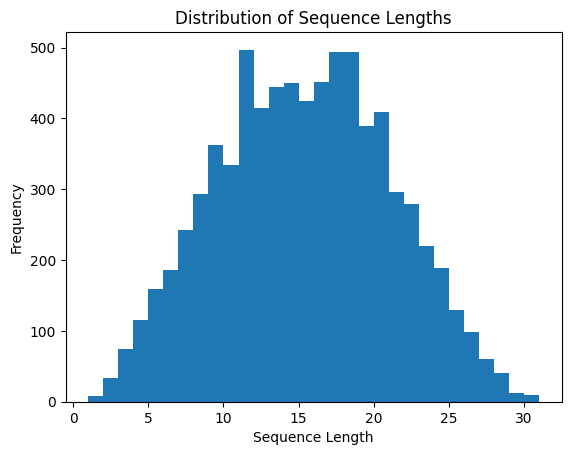

In [ ]:
#Lets find a good padding value for vectorization!

text_data = train_copy["text"]

# Calculate the lengths of each sequence (number of tokens)
sequence_lengths = text_data.apply(lambda x: len(x.split()))

# Create a histogram
plt.hist(sequence_lengths, bins=30)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Distribution of Sequence Lengths")
plt.show()

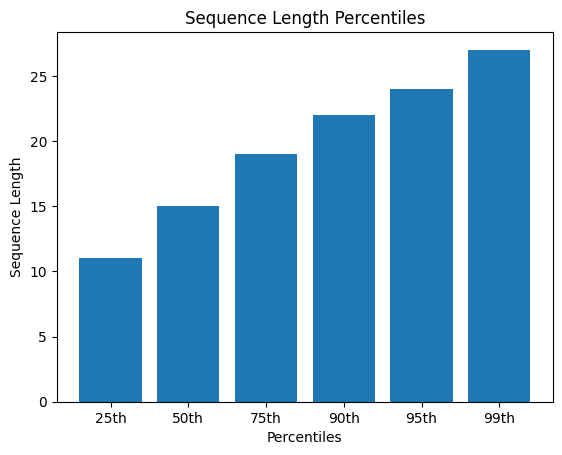

In [ ]:
text_data= train_copy["text"]

# Calculate the lengths of each sequence (number of tokens)
sequence_lengths = text_data.apply(lambda x: len(x.split()))

# Calculate percentiles
percentiles = np.percentile(sequence_lengths, [25, 50, 75, 90, 95, 99])

# Print percentiles
plt.bar(range(len(percentiles)), percentiles)
plt.xticks(range(len(percentiles)), [f"{p}th" for p in [25, 50, 75, 90, 95, 99]])
plt.xlabel("Percentiles")
plt.ylabel("Sequence Length")
plt.title("Sequence Length Percentiles");

>I will use 25 as this captures almost all of the tweets

In [ ]:
#Now, I will embed the text so a NLP can be used on it. First the vectorization layer
vectorizer =  tf.keras.layers.TextVectorization(max_tokens=1000,
                                                standardize='lower_and_strip_punctuation',
                                                output_mode='int',
                                                pad_to_max_tokens=True,
                                                output_sequence_length=25)

In [ ]:
vectorizer.adapt(train_copy["text"])

In [ ]:
#Now the embedding layer
'''
embedding_layer = tf.keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()),
                                            output_dim=128,
                                            input_length=25)
'''
embedding_layer = tf.keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()),
                                            output_dim=128)

## Split data into training and validation sets

In [ ]:
X = train_copy["text"]
y = train_copy["target"]

In [ ]:
X.shape, y.shape

((7613,), (7613,))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  random_state=42)

In [ ]:
X_train.shape, y_train.shape

((6090,), (6090,))

In [ ]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
def make_preds(model_name):
  model = tf.keras.models.load_model('/content/drive/MyDrive/nlp-disaster-classification/models/' + model_name)

  preds = model.predict(X_val)

  #reshaping array to fit in comparison function below
  preds = np.argmax(preds, axis=1)

  results = calculate_results(y_true=y_val,
                              y_pred=preds)
  print(results)

## Baseline Model (SKL)

In [ ]:
#create tokenization and modeling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB()),
])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/nlp-disaster-classification/models/model_0.keras", save_best_only=True)

#fit pipeline to training data
model_0_history = model_0.fit(X=X_train, y=y_train)

In [ ]:
#Evaluate baseline model
baseline_score = model_0.score(X_val, y_val)
baseline_score

0.7997373604727511

## Transfer Learning Model (BERT Tiny)
>BERT's model takes in plain text to interpret so it will be passed the initial version of the text before any vectorization or embedding.

>https://keras.io/api/keras_nlp/models/bert/bert_classifier/

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/nlp-disaster-classification/models/model_1.keras", save_best_only=True)


# Load architecture and weights from preset
model_1 = keras_nlp.models.BertClassifier.from_preset("bert_tiny_en_uncased", num_classes=2)

# Load randomly initialized model from preset architecture
model_1_history = model_1.fit(x=X_train,
                              y=y_train,
                              batch_size=16,
                              epochs=20,
                              validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

100%|██████████| 507/507 [00:00<00:00, 318kB/s]
100%|██████████| 16.8M/16.8M [00:00<00:00, 21.3MB/s]
100%|██████████| 547/547 [00:00<00:00, 607kB/s]
100%|██████████| 226k/226k [00:00<00:00, 998kB/s] 


Epoch 1/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 186s 308ms/step - loss: 0.6083 - sparse_categorical_accuracy: 0.6809 - val_loss: 0.4507 - val_sparse_categorical_accuracy: 0.8024
Epoch 2/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step - loss: 0.4573 - sparse_categorical_accuracy: 0.7935 - val_loss: 0.4057 - val_sparse_categorical_accuracy: 0.8319
Epoch 3/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - loss: 0.3850 - sparse_categorical_accuracy: 0.8338 - val_loss: 0.3997 - val_sparse_categorical_accuracy: 0.8293
Epoch 4/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - loss: 0.3255 - sparse_categorical_accuracy: 0.8704 - val_loss: 0.4219 - val_sparse_categorical_accuracy: 0.8345
Epoch 5/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - loss: 0.2839 - sparse_categorical_accuracy: 0.8913 - val_loss: 0.4488 - val_sparse_categorical_accuracy: 0.8168
Epoch 6/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step - loss: 0.2315 - sparse_categorical_accuracy: 0.9150 - val_loss: 0.4858 - val_sparse_categorical_accurac

In [ ]:
model_1 = tf.keras.models.load_model('/content/drive/MyDrive/nlp-disaster-classification/models/model_1.keras')

In [ ]:
model_1_preds = model_1.predict(test["text"])

#reshaping array to fit in comparison function below
model_1_preds = np.argmax(model_1_preds, axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step


In [ ]:
model_1_preds.shape

(3263,)

In [ ]:
make_preds("model_1.keras")

48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step
{'accuracy': 82.9284307288247, 'precision': 0.8293444618354476, 'recall': 0.8292843072882469, 'f1': 0.8279800884040511}


## BERT Small Sized

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/nlp-disaster-classification/models/model_2.keras", save_best_only=True)


# Load architecture and weights from preset
model_2 = keras_nlp.models.BertClassifier.from_preset("bert_small_en_uncased", num_classes=2)

# Load randomly initialized model from preset architecture
model_2_history = model_2.fit(x=X_train,
                              y=y_train,
                              batch_size=16,
                              epochs=20,
                              validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

100%|██████████| 508/508 [00:00<00:00, 1.20MB/s]
100%|██████████| 110M/110M [00:03<00:00, 37.5MB/s]
100%|██████████| 547/547 [00:00<00:00, 319kB/s]
100%|██████████| 226k/226k [00:00<00:00, 1.00MB/s]


Epoch 1/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 243s 443ms/step - loss: 0.5139 - sparse_categorical_accuracy: 0.7459 - val_loss: 0.4123 - val_sparse_categorical_accuracy: 0.8267
Epoch 2/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 101s 265ms/step - loss: 0.3504 - sparse_categorical_accuracy: 0.8580 - val_loss: 0.4283 - val_sparse_categorical_accuracy: 0.8286
Epoch 3/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 103s 270ms/step - loss: 0.2510 - sparse_categorical_accuracy: 0.9023 - val_loss: 0.4914 - val_sparse_categorical_accuracy: 0.8280
Epoch 4/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 108s 282ms/step - loss: 0.1828 - sparse_categorical_accuracy: 0.9312 - val_loss: 0.6577 - val_sparse_categorical_accuracy: 0.7899


In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/nlp-disaster-classification/models/model_3.keras", save_best_only=True)

# Load randomly initialized model from preset architecture
model_2_history = model_2.fit(x=X_train,
                              y=y_train,
                              batch_size=16,
                              epochs=20,
                              validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 102s 267ms/step - loss: 0.3467 - sparse_categorical_accuracy: 0.8505 - val_loss: 0.4061 - val_sparse_categorical_accuracy: 0.8260
Epoch 2/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 103s 269ms/step - loss: 0.2554 - sparse_categorical_accuracy: 0.9018 - val_loss: 0.4846 - val_sparse_categorical_accuracy: 0.8306
Epoch 3/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 100s 261ms/step - loss: 0.1834 - sparse_categorical_accuracy: 0.9298 - val_loss: 0.5959 - val_sparse_categorical_accuracy: 0.8175
Epoch 4/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 111s 291ms/step - loss: 0.1372 - sparse_categorical_accuracy: 0.9460 - val_loss: 0.7263 - val_sparse_categorical_accuracy: 0.7866


In [ ]:
model_2 = tf.keras.models.load_model('/content/drive/MyDrive/nlp-disaster-classification/models/model_2.keras')

make_preds("model_2.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:727: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 148 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step
{'accuracy': 82.66579120157583, 'precision': 0.845665845020169, 'recall': 0.8266579120157583, 'f1': 0.8197693010829347}


## Hypertuning BERT

>It does seem that giving the model more columns to work with slightly improves the score! Now lets try hypertuning the model by making the last few layers of BERT trainable.

In [ ]:
model_3 = tf.keras.models.load_model('/content/drive/MyDrive/nlp-disaster-classification/models/model_2.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:727: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 148 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [ ]:
model_3.layers

[<InputLayer name=padding_mask, built=True>,
 <InputLayer name=segment_ids, built=True>,
 <InputLayer name=token_ids, built=True>,
 <BertBackbone name=bert_backbone, built=True>,
 <Dropout name=classifier_dropout, built=True>,
 <Dense name=logits, built=True>]

In [ ]:
bert_backbone = model_3.layers[3]
bert_layers = bert_backbone.layers
bert_layers

[<InputLayer name=token_ids, built=True>,
 <ReversibleEmbedding name=token_embedding, built=True>,
 <InputLayer name=segment_ids, built=True>,
 <PositionEmbedding name=position_embedding, built=True>,
 <Embedding name=segment_embedding, built=True>,
 <Add name=embeddings_add, built=True>,
 <LayerNormalization name=embeddings_layer_norm, built=True>,
 <Dropout name=embeddings_dropout, built=True>,
 <InputLayer name=padding_mask, built=True>,
 <TransformerEncoder name=transformer_layer_0, built=True>,
 <TransformerEncoder name=transformer_layer_1, built=True>,
 <TransformerEncoder name=transformer_layer_2, built=True>,
 <TransformerEncoder name=transformer_layer_3, built=True>,
 <Dense name=pooled_dense, built=True>]

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(bert_layers):
  print(layer_number, layer.name, layer.trainable)

0 token_ids True
1 token_embedding True
2 segment_ids True
3 position_embedding True
4 segment_embedding True
5 embeddings_add True
6 embeddings_layer_norm True
7 embeddings_dropout True
8 padding_mask True
9 transformer_layer_0 True
10 transformer_layer_1 True
11 transformer_layer_2 True
12 transformer_layer_3 True
13 pooled_dense True


In [ ]:
#Testing how the model will do if all these layers are false
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/nlp-disaster-classification/models/model_3.keras", save_best_only=True)


# Load architecture and weights from preset
model_3 = keras_nlp.models.BertClassifier.from_preset("bert_small_en_uncased", num_classes=2)

In [ ]:
model_3.layers

[<InputLayer name=padding_mask, built=True>,
 <InputLayer name=segment_ids, built=True>,
 <InputLayer name=token_ids, built=True>,
 <BertBackbone name=bert_backbone, built=True>,
 <Dropout name=classifier_dropout, built=True>,
 <Dense name=logits, built=True>]

In [ ]:
bert_backbone = model_3.layers[3]
bert_layers = bert_backbone.layers
bert_layers

# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(bert_layers):
  print(layer_number, layer.name, layer.trainable)

0 token_ids True
1 token_embedding True
2 segment_ids True
3 position_embedding True
4 segment_embedding True
5 embeddings_add True
6 embeddings_layer_norm True
7 embeddings_dropout True
8 padding_mask True
9 transformer_layer_0 True
10 transformer_layer_1 True
11 transformer_layer_2 True
12 transformer_layer_3 True
13 pooled_dense True


In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(bert_layers):
  layer.trainable = False

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(bert_layers):
  print(layer_number, layer.name, layer.trainable)

0 token_ids False
1 token_embedding False
2 segment_ids False
3 position_embedding False
4 segment_embedding False
5 embeddings_add False
6 embeddings_layer_norm False
7 embeddings_dropout False
8 padding_mask False
9 transformer_layer_0 False
10 transformer_layer_1 False
11 transformer_layer_2 False
12 transformer_layer_3 False
13 pooled_dense False


In [ ]:
# Load randomly initialized model from preset architecture
model_3_history = model_3.fit(x=X_train,
                              y=y_train,
                              batch_size=16,
                              epochs=20,
                              validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 103s 185ms/step - loss: 0.6616 - sparse_categorical_accuracy: 0.5974 - val_loss: 0.6123 - val_sparse_categorical_accuracy: 0.7203
Epoch 2/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 54s 140ms/step - loss: 0.6069 - sparse_categorical_accuracy: 0.7043 - val_loss: 0.5794 - val_sparse_categorical_accuracy: 0.7531
Epoch 3/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 101s 264ms/step - loss: 0.5822 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.5586 - val_sparse_categorical_accuracy: 0.7676
Epoch 4/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 42s 110ms/step - loss: 0.5656 - sparse_categorical_accuracy: 0.7346 - val_loss: 0.5435 - val_sparse_categorical_accuracy: 0.7787
Epoch 5/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 45s 117ms/step - loss: 0.5518 - sparse_categorical_accuracy: 0.7419 - val_loss: 0.5322 - val_sparse_categorical_accuracy: 0.7833
Epoch 6/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 47s 121ms/step - loss: 0.5457 - sparse_categorical_accuracy: 0.7417 - val_loss: 0.5236 - val_sparse_categorical_a

In [ ]:
make_preds("model_3.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step
{'accuracy': 79.57977675640184, 'precision': 0.7957699777612536, 'recall': 0.7957977675640184, 'f1': 0.7936667863502967}


In [ ]:
model_3_hypertuned = tf.keras.models.load_model('/content/drive/MyDrive/nlp-disaster-classification/models/model_3.keras')

bert_backbone = model_3_hypertuned.layers[3]
bert_layers = bert_backbone.layers
bert_layers

# Calculate the total number of layers in bert_layers
total_layers = len(bert_layers)

# Calculate the starting index for the last five layers
start_index = total_layers - 5

# Make the last five layers trainable, and set the rest as non-trainable
for layer_number, layer in enumerate(bert_layers):
    if layer_number >= start_index:
        layer.trainable = True
    else:
        layer.trainable = False

# Check the trainable status of each layer
for layer_number, layer in enumerate(bert_layers):
    print(layer_number, layer.name, layer.trainable)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:727: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


0 token_ids False
1 token_embedding False
2 segment_ids False
3 position_embedding False
4 segment_embedding False
5 embeddings_add False
6 embeddings_layer_norm False
7 embeddings_dropout False
8 padding_mask False
9 transformer_layer_0 True
10 transformer_layer_1 True
11 transformer_layer_2 True
12 transformer_layer_3 True
13 pooled_dense True


In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/nlp-disaster-classification/models/model_3_hypertuned.keras", save_best_only=True)



history_model_3_hypertuned = model_3_hypertuned.fit(x=X_train,
                                                    y=y_train,
                                                    batch_size=16,
                                                    initial_epoch=5,
                                                    epochs=20,
                                                    validation_data=(X_val, y_val),
                                                    callbacks=[early_stopping, model_checkpoint])

Epoch 6/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 190s 376ms/step - loss: 0.4859 - sparse_categorical_accuracy: 0.7783 - val_loss: 0.4031 - val_sparse_categorical_accuracy: 0.8273
Epoch 7/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 95s 248ms/step - loss: 0.3548 - sparse_categorical_accuracy: 0.8507 - val_loss: 0.4554 - val_sparse_categorical_accuracy: 0.8162
Epoch 8/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 116s 303ms/step - loss: 0.2841 - sparse_categorical_accuracy: 0.8799 - val_loss: 0.5151 - val_sparse_categorical_accuracy: 0.7971
Epoch 9/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 155s 406ms/step - loss: 0.2036 - sparse_categorical_accuracy: 0.9258 - val_loss: 0.5889 - val_sparse_categorical_accuracy: 0.7905


In [ ]:
model_3 = tf.keras.models.load_model('/content/drive/MyDrive/nlp-disaster-classification/models/model_3.keras')

make_preds("model_3.keras")

48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step
{'accuracy': 79.57977675640184, 'precision': 0.7957699777612536, 'recall': 0.7957977675640184, 'f1': 0.7936667863502967}


>It seems that hypertuning has not resulted in a more accurate model.


## RoBERTa
>https://keras.io/api/keras_nlp/models/roberta/roberta_classifier/#robertaclassifier-class

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/nlp-disaster-classification/models/model_4.keras", save_best_only=True)


# Load architecture and weights from preset
model_4 = keras_nlp.models.RobertaClassifier.from_preset("roberta_base_en",
                                                         num_classes=2)

# Load randomly initialized model from preset architecture
model_4_history = model_4.fit(x=X_train,
                              y=y_train,
                              batch_size=8,
                              epochs=20,
                              validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

100%|██████████| 498/498 [00:00<00:00, 462kB/s]
100%|██████████| 474M/474M [00:12<00:00, 40.5MB/s]
100%|██████████| 463/463 [00:00<00:00, 410kB/s]
100%|██████████| 446k/446k [00:00<00:00, 3.26MB/s]
100%|██████████| 0.99M/0.99M [00:00<00:00, 6.90MB/s]


Epoch 1/20
762/762 ━━━━━━━━━━━━━━━━━━━━ 980s 1s/step - loss: 0.5090 - sparse_categorical_accuracy: 0.7513 - val_loss: 0.4976 - val_sparse_categorical_accuracy: 0.8168
Epoch 2/20
762/762 ━━━━━━━━━━━━━━━━━━━━ 683s 895ms/step - loss: 0.3495 - sparse_categorical_accuracy: 0.8667 - val_loss: 0.4630 - val_sparse_categorical_accuracy: 0.8253
Epoch 3/20
762/762 ━━━━━━━━━━━━━━━━━━━━ 589s 772ms/step - loss: 0.2635 - sparse_categorical_accuracy: 0.9072 - val_loss: 0.5006 - val_sparse_categorical_accuracy: 0.8043
Epoch 4/20
762/762 ━━━━━━━━━━━━━━━━━━━━ 662s 867ms/step - loss: 0.2147 - sparse_categorical_accuracy: 0.9213 - val_loss: 0.5604 - val_sparse_categorical_accuracy: 0.8227
Epoch 5/20
762/762 ━━━━━━━━━━━━━━━━━━━━ 649s 850ms/step - loss: 0.1667 - sparse_categorical_accuracy: 0.9413 - val_loss: 0.6383 - val_sparse_categorical_accuracy: 0.8247


In [ ]:
make_preds("model_4.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:727: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 402 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 53s 937ms/step
{'accuracy': 82.53447143795141, 'precision': 0.8250544688656578, 'recall': 0.8253447143795141, 'f1': 0.8251634490011868}


## Combining random forest and BERT

In [106]:
df = train.copy()

df = df.drop("location", axis=1)

#Filling missing location and keyword data
fill_value = "Unknown"

missing_keyword = df["keyword"].isna()

df.loc[missing_keyword, "keyword"] = fill_value

In [107]:
#One hot encoding keyword column
df = pd.get_dummies(df, columns=["keyword"])

In [108]:
X_train, X_val, y_train, y_val = train_test_split(df.drop("target", axis=1),
                                                  df["target"],
                                                  test_size=0.2,
                                                  random_state=42)

In [109]:
rf = RandomForestClassifier()

rf.fit(X=X_train.drop("text", axis=1), y=y_train)

RandomForestClassifier()

In [110]:
# Make predictions on the test set
y_pred = rf.predict(X_val.drop("text", axis=1))

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.71


In [111]:
bert_model = tf.keras.models.load_model('/content/drive/MyDrive/nlp-disaster-classification/models/model_2.keras')



/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:727: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 148 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [112]:
# Make preds with each model and take mean of each score make sure to load best bert model
rf_preds = rf.predict_proba(X_val.drop("text", axis=1))

bert_preds = bert_model.predict(X_val["text"])

rf_preds, bert_preds

48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step


(array([[0.80994586, 0.19005414],
        [0.85332107, 0.14667893],
        [0.44073047, 0.55926953],
        ...,
        [0.39084917, 0.60915083],
        [0.24287486, 0.75712514],
        [0.56812146, 0.43187854]]),
 array([[ 0.93454427, -1.1919273 ],
        [ 1.1842825 , -1.0467347 ],
        [ 0.14348283, -0.18199328],
        ...,
        [-0.94333744,  1.0092504 ],
        [-1.3504039 ,  1.3213407 ],
        [ 0.6311181 , -0.55425614]], dtype=float32))

In [113]:
# Averaging predictions
combined_preds = (rf_preds + bert_preds) / 2  # Simple average

In [114]:
np.argmax(combined_preds, axis=1)

array([0, 0, 0, ..., 1, 1, 0])

In [115]:
# Calculate accuracy
accuracy = accuracy_score(y_val, np.argmax(combined_preds, axis=1))
print(f"Accuracy: {accuracy:.5f}")

Accuracy: 0.82600


In [116]:
df = test.drop(["text", "location"], axis=1)
df.columns

Index(['keyword'], dtype='object')

In [117]:
# Make preds with each model and take mean of each score make sure to load best bert model
#One hot encoding keyword column
df = test.drop(["text", "location"], axis=1)
df["keyword_Unknown"] = 0
df = pd.get_dummies(df, columns=["keyword"])

rf_preds = rf.predict_proba(df)

bert_preds = bert_model.predict(test["text"])

102/102 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step


In [118]:
# Averaging predictions
combined_preds = (rf_preds + bert_preds) / 2  # Simple average
combined_preds = np.argmax(combined_preds, axis=1)

In [119]:
df = pd.DataFrame({"id": test.index, "target": combined_preds})

df.to_csv('predictions-combo.csv', index=False)

## Exporting predictions

In [120]:
best_model = tf.keras.models.load_model('/content/drive/MyDrive/nlp-disaster-classification/models/model_2.keras')

preds = best_model.predict(test["text"])

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:727: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 148 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step


In [121]:
preds = np.argmax(preds, axis=1)

In [122]:
df = pd.DataFrame({"id": test.index, "target": preds})

df.to_csv('predictions.csv', index=False)